# Factor analysis of human activity patterns

## Goals

We aim to understand the following:

* That basic principles of vector geometry and probability can yield insights about data.

* That probability can be used to gain insights from a sample of data that represents a population.

* That data can have high dimension that precludes direct visualization, yet *dimension reduction* based on principles of geometry and probability yield insights.

* That human activity patterns throughout the 24 hour day exhibit complex patterns of variation that can be revealed through statistical analysis.

In [27]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

## Empirical research and statistical science

*Empirical research* is an approach to learning about the natural world by making measurements, collecting data, and using these data to assess mechanistic hypotheses about the natural world.

*Statistics* is the methodological field that develops methods for analyzing data and seeks to understand their properties.  

## Thinking about data in terms of geometry and probability

Many types of data can be seen as *vectors* that sit in a *vector space*.  For example, if we collect data on human subjects and collect their age, BMI, and blood pressure, these data constitute a three-dimensional vector that sits in ${\mathbb R}^3$.

Our goal is to understand data that may have any dimension, but we will use data in two dimensions as an illustration, since we can easily graph such data.  The mathematical tools that we will be using here are basic vector geometry, linear algebra, and probability.

Suppose we observe the data plotted as grey points below.  If it helps to make things very concrete, you can think of the horizontal axis as being a person's height and the vertical axis as being their weight.

In [28]:
mn = np.r_[3, 2]
n = 100
B = np.asarray([[1, 1], [0, 1]])
np.random.seed(123)
X = mn + np.dot(np.random.normal(size=(n, 2)), B)

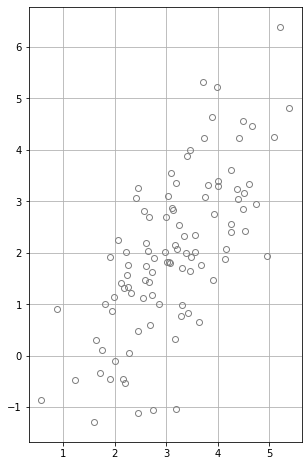

In [29]:
plt.figure(figsize=(8, 8))
plt.grid(True)
ax = plt.plot(X[:, 0], X[:, 1], "o", mfc="none", color="grey");
plt.gca().set_aspect("equal", "box")

A basic summary of a collection of points is the "centroid" (center of mass, mean, average value) plotted as a blue dot below.

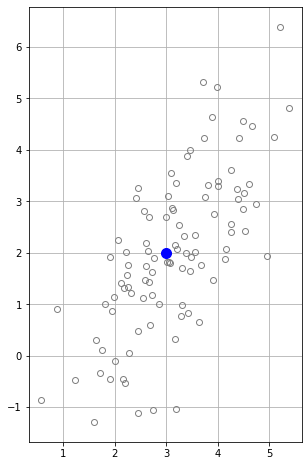

In [30]:
plt.figure(figsize=(8, 8))
plt.grid(True)
plt.plot(X[:, 0], X[:, 1], "o", mfc="none", color="grey")
plt.plot([mn[0]], [mn[1]], "o", color="blue", ms=10)
plt.gca().set_aspect("equal", "box")

The centroid minimizes the average squared length to all points in the data, illustrated by the lines plotted below:

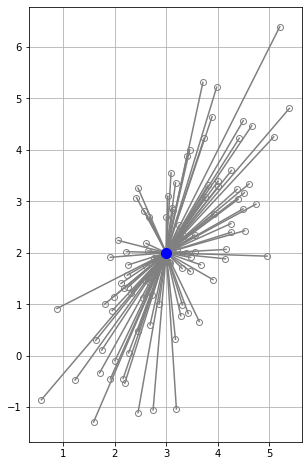

In [31]:
plt.figure(figsize=(8, 8))
plt.grid(True)
plt.plot(X[:, 0], X[:, 1], "o", mfc="none", color="grey")
plt.plot([mn[0]], [mn[1]], "o", color="blue", ms=10)
for i in range(X.shape[0]):
    plt.plot([mn[0], X[i, 0]], [mn[1], X[i, 1]], "-", color="grey")
plt.plot([mn[0]], [mn[1]], "o", color="blue", ms=10)
plt.gca().set_aspect("equal", "box");

Put mathematically, the centroid (mean) is 

$$
\hat{\mu} = {\rm argmin}_\mu \sum_{i=1}^n \|x_i - \mu\|^2,
$$

where $x_i \in {\mathbb R}^p$ is one of the observed data vectors and $\mu \in {\mathbb R}^p$ is the centroid.  The "L2 norm" $\|\cdot\|$ is defined by $\|u\|^2 = \sum_i u_i^2$.

Now that we have defined the mean, we turn our attention to the "deviations from the mean".  We can represent each of these deviations as a linear combination of "principal components" or "eigenvectors".

* The principal components are ordered based on how much variance they explain

* The principal components are orthogonal to each other

* The "scores" for representing each point in terms of the various principal components are statistically uncorrelated 

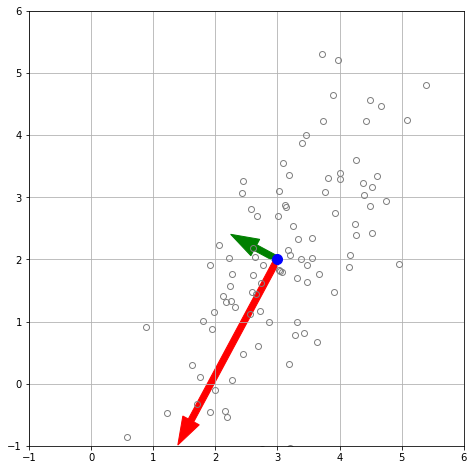

In [32]:
a, b = np.linalg.eig(np.cov(X.T))
plt.figure(figsize=(8, 8))
plt.xlim(-1, 6)
plt.ylim(-1, 6)
plt.grid(True)
plt.plot(X[:, 0], X[:, 1], "o", mfc="none", color="grey")
plt.plot([mn[0]], [mn[1]], "o", color="blue", ms=10)
plt.arrow(mn[0], mn[1], a[1]*b[0, 1], a[1]*b[1, 1], width=0.1, color="red")
plt.arrow(mn[0], mn[1], a[0]*b[0, 0], a[0]*b[1, 0], width=0.1, color="green");
plt.gca().set_aspect("equal", "box")

Each observed vector $x_i$ can be uniquely expressed as a linear combination of the principal components. The coefficients of these representations are known as *scores*.

score 1:  0.7004280361862794
score 2:  -0.6777655162179866


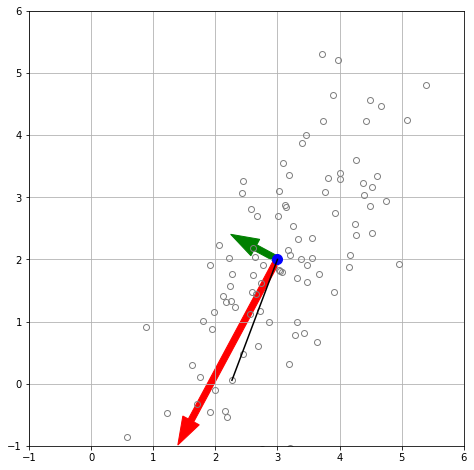

In [33]:
plt.figure(figsize=(8, 8))
plt.xlim(-1, 6)
plt.ylim(-1, 6)
plt.grid(True)
plt.plot(X[:, 0], X[:, 1], "o", mfc="none", color="grey")
plt.plot([mn[0]], [mn[1]], "o", color="blue", ms=10)
plt.arrow(mn[0], mn[1], a[1]*b[0, 1], a[1]*b[1, 1], width=0.1, color="red")
plt.arrow(mn[0], mn[1], a[0]*b[0, 0], a[0]*b[1, 0], width=0.1, color="green");
i = 43
s = np.dot(b.T, X[i, :] - mn) / a
plt.plot([mn[0], X[i, 0]], [mn[1], X[i, 1]], "-", color="black")
print("score 1: ", s[1])
print("score 2: ", s[0])
plt.gca().set_aspect("equal", "box")

As noted above, the scores are uncorrelated -- knowing that an observation has, say, a high value for score 1 provides no informationabout the values of the other scores for that observation.

array([[ 1.00000000e+00, -2.89901007e-16],
       [-2.89901007e-16,  1.00000000e+00]])

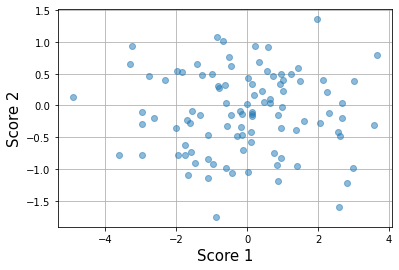

In [34]:
score1 = np.dot(X - mn, b[:, 1])
score2 = np.dot(X - mn, b[:, 0])
plt.grid(True)
plt.plot(score1, score2, "o", alpha=0.5)
plt.xlabel("Score 1", size=15)
plt.ylabel("Score 2", size=15)
np.corrcoef(score1, score2)

## Analysis of human physical activity data

We have around 29,000 person/days of hourly physical activity data. Physical activity is measured by an accelerometer that captures movement of any type. The data that we work with here are summarized to produce one hourly activity value per hour.  Therefore, these are 24-dimensional data, since for each person/day we obtain one number for each hour within in a day.  

Due to the dimensionality, we cannot plot the data directly (in 24 dimensional space), but the geometric techniques discussed above can still be applied here. 

The scientific context for this analysis is to understand variation in human activity between people, and to assess how this variation associates with known person-level characteristics.  This is a type of *circadian* analysis, since we are observing patterns that reflect behavior over the 24 hour day.

In [36]:
da = pd.read_csv("https://dept.stat.lsa.umich.edu/~kshedden/PAXHR_H.csv.gz")
da = da.query("PAXMTSH > 0")
dd = pd.read_csv("https://dept.stat.lsa.umich.edu/~kshedden/DEMO_H.csv.gz")
dd = dd.query("RIDAGEYR >= 18")
da = da[da.SEQN.isin(dd.SEQN)]

In [ ]:
da["HOUR"] = np.floor(da["PAXSSNHP"] / (80*60*60) % 24)
da = da.groupby(["SEQN", "PAXDAYH", "HOUR"]).first()

In [ ]:
plt.hist(da["PAXMTSH"])
plt.xlabel("Raw activity", size=15)
plt.ylabel("Frequency", size=15);

In [ ]:
plt.hist(np.log(1 + da["PAXMTSH"]))
da["logPAXMTSH"] = np.log(1 + da["PAXMTSH"])
plt.xlabel("Log activity", size=15)
plt.ylabel("Frequency", size=15);

In [ ]:
act = da["logPAXMTSH"].unstack().dropna()
lux = da["PAXLXSH"].unstack().dropna()
act.shape

The mean is plotted below. 

In [ ]:
act_mean = act.mean(0)
plt.grid(True)
plt.plot(act_mean, label="Activity")
plt.xlabel("Time (UTC)", size=15)
plt.ylabel("Mean", size=15);

In [ ]:
act_cen = act - act_mean
u,s,vt = np.linalg.svd(act_cen, 0)
v = vt.T
for j in range(v.shape[1]):
    sc = np.dot(act_cen, v[:, j])
    if np.mean(sc < 0) > 0.5:
        v[:, j] *= -1

## Factors of human activity

As in the two-dimensional example above, we can use principal components to identify a natural set of mutually orthogonal axes for the data.  

### Assessing dimensionality

Each principal component axis has an "importance" reflected in its *eigenvalue*.  The "scree plot" below shows the eigenvalues in log-space.

If $\lambda_i$ is the $i^{\rm th}$ largest eigenvalue, we may posit that $\lambda_i = ci^\alpha$.  In log-space this "power law" relationship yields $\log \lambda_i = \log(c) + \alpha\log(i)$.  Tht is, $\log(c)$ is linear in $\log(i$).

In [ ]:
pos = np.arange(1, v.shape[0]+1)
plt.grid(True)
plt.plot(np.log(pos), np.log(s), "-o")
plt.xlabel("Log position", size=15)
plt.ylabel("Log eigenvalue", size=15);

In [ ]:
s2 = np.cumsum(s**2)
s2 /= s2.max()
plt.grid(True)
plt.plot(range(1, len(s2)+1), s2)
plt.xlabel("Number of factors", size=15)
plt.ylabel("Fraction of variance explained", size=13)

### Understanding the loading vectors

Below we plot the "loading vectors" for the dominant three principal components:

In [ ]:
plt.figure(figsize=(8, 5))
plt.axes([0.1, 0.1, 0.77, 0.9])
plt.grid(True)
plt.plot(v[:,0], label="PC1")
plt.plot(v[:,1], label="PC2")
plt.plot(v[:,2], label="PC3")
plt.xlabel("Time (UTC)", size=15)
plt.ylabel("Loading", size=15)
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb, "center right")
leg.draw_frame(False)

It is easier to interpret the meaning of each principal component by plotting the fitted mean along each PC axis:

In [ ]:
seqn = [x[0] for x in act.index]
act_scores = np.dot(act_cen, v[:, 0:3])
act_scores = pd.DataFrame({"SEQN": seqn, "act0": act_scores[:, 0], "act1": act_scores[:, 1], "act2": act_scores[:, 2]})

for j in [0, 1, 2]:
    s = np.std(act_scores["act%d" % j])
    plt.figure()
    plt.grid(True)
    plt.title("Factor %d" % (j + 1))
    plt.plot(act_mean, color="black")
    plt.plot(act_mean + v[:, j] * s, color="red")
    plt.plot(act_mean - v[:, j] * s, color="blue")
    plt.xlabel("Hour (UTC)", size=15)
    plt.ylabel("Activity", size=15)

Based on the plots above we can reach the following conclusions:

* Factor 1 captures the timing of the circadian cycle, with higher scores corresponding to a cycle shifted later in time.

* Factor 2 largely reflects the amplitude of the circadian cycle.

* Factor 3 reflects a uniform shift in the circadian cycle.

Another way to gain insight into the variation captured by each principal component is to consider the PC scores in relation to other variables.  For each subject in NHANES we have many potentially relevant variables.  First we can consider how the PC scores vary with age: 

In [ ]:
actx = pd.merge(dd, act_scores, on="SEQN")
plt.figure(figsize=(8, 5))
plt.grid(True)
n = actx.shape[0]
for j in [0, 1, 2]:
    lw = sm.nonparametric.lowess(actx["act%d" % j], actx["RIDAGEYR"])
    plt.plot(lw[:, 0], lw[:, 1], label=j+1)
    r = np.corrcoef(actx["act%d" % j], actx["RIDAGEYR"])[0, 1]
    print("%.3f(%.3f)" % (r, np.sqrt(1/n)))
ha,lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb, "center right")
leg.draw_frame(False)
plt.xlabel("Age", size=15)
plt.ylabel("Score", size=15);

Based on the plot above we can make the following observations:

* Younger people have higher scores on factor 1, indicating that the activity pattern of younger people has greater amplitude and is shifted later in time.  This pattern is nonlinear with the scores decreasing from age 18 to around 50 and stabilizing thereafter.

* Scores for factor 2 increase linearly with age -- older people have a greater amplitude in their circadian patterns.

* Scores for factor 3 are somewhat "U shaped" -- the scores increase from age 18 to 40 and decrease thereafter.  This suggests that physical activity increases slightly from age 18 to around 40 and drops thereafter, with the steepest declines after age 60.

All three relationships are statistically significant.

We can do a similar analysis looking at sex differences (RIAGENDR=2 is females and RIAGENDR=1 is males):

In [ ]:
actx.groupby("RIAGENDR")[["act0", "act1", "act2"]].mean()

In [ ]:
for k in range(3):
    fe = actx.query("RIAGENDR == 2")["act%d" % k]
    ma = actx.query("RIAGENDR == 1")["act%d" % k]
    tt = sm.stats.ttest_ind(fe, ma)
    print("%d p=%f" % (k, tt[1]))

Based on the results above we can draw the following conclusions:

* There is no statistical evidence for a sex difference in terms of the factor 1 scores.  That is, the timing of the circadian pattern may not differ between females and males.

* Females have greater scores for factor 2, suggesting that females have greater amplitude of circadian physical activity than males.

* Females have greater scores for factor 3, suggesting that females are somewhat more active than males.

Note that this is not a multivariable analysis -- we are considering age and sex separately.  However females tend to be older than males (since females have longer life expectancy).